In [23]:
##------- 1. Load libraries & model
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [7]:
#load data
df = pd.read_csv("NikeProductDescriptions.csv")
#show basic information like the nb of nulls an type of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None


In [16]:
#filter subtitles keep only the target subtitles
target_subtitles = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
df_filtered = df[df['Subtitle'].isin(target_subtitles) | df['Subtitle'].str.contains("Shorts", case=False)].copy()
df_filtered['Subtitle'] = df_filtered['Subtitle'].apply(lambda x: "Shorts" if "Shorts" in x else x)
#simple clean function to remove stopwords and tokenize the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens
#apply tokenization in the product description
df_filtered['tokens'] = df_filtered['Product Description'].apply(lambda x: ' '.join(clean_text(str(x))))

In [17]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [18]:
# Convert column to list of strings
descriptions = df_filtered['tokens'].tolist()

In [24]:
# 3. Function to get mean embedding from BERT last hidden layer
def get_mean_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  
    return last_hidden_state.squeeze(0).mean(dim=0).numpy()

# 4. Compute embeddings for all descriptions
embeddings = np.array([get_mean_bert_embedding(text) for text in tqdm(df_filtered['tokens'])])

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:13<00:00, 11.72it/s]


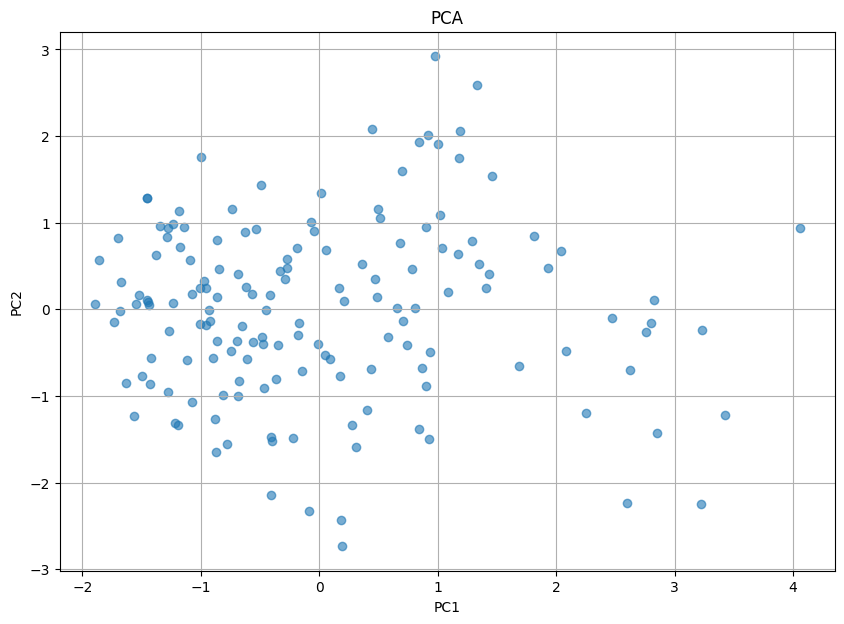

top contributing PC1: [308 431 435 367 578 418 280 289 419 672]
top contributing to PC2: [552  67  42 520 282 197 436 400 566  48]


In [25]:
# cls_embeddings = last_hidden_states[:, 0, :] 

pca = PCA(n_components=2)
reduced_cls = pca.fit_transform(embeddings) 

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced_cls[:, 0], reduced_cls[:, 1], alpha=0.6)
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

loadings = pca.components_ 
top_pc1_dims = np.argsort(np.abs(loadings[0]))[::-1][:10]
top_pc2_dims = np.argsort(np.abs(loadings[1]))[::-1][:10]
print("top contributing PC1:", top_pc1_dims)
print("top contributing to PC2:", top_pc2_dims)

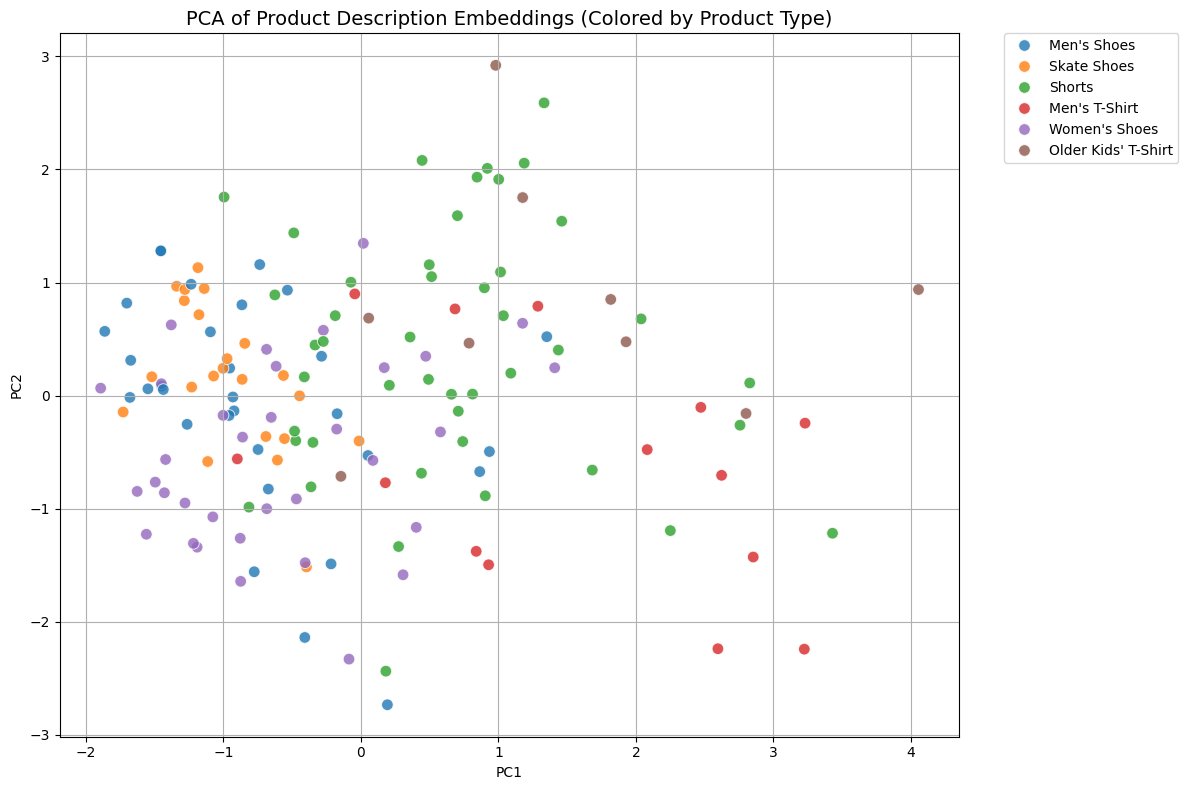

In [26]:
# Plot with labels
labels = df_filtered['Subtitle'].tolist() 
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_cls[:, 0], y=reduced_cls[:, 1], hue=labels, palette='tab10', s=70, alpha=0.8)
plt.title('PCA of Product Description Embeddings (Colored by Product Type)', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.show()